In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Import the libraries

In [ ]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
df = pd.read_pickle("/content/gdrive/MyDrive/BertNet/image_sale_224x224.pkl")

print("\nSample image shape:", df['image_pixel'].iloc[0].shape)
print("High sale distribution:")
print(df['high_sale'].value_counts(normalize=True))


Sample image shape: (224, 224, 3)
High sale distribution:
high_sale
1    0.591181
0    0.408819
Name: proportion, dtype: float64


#Extracting the individual image from the product

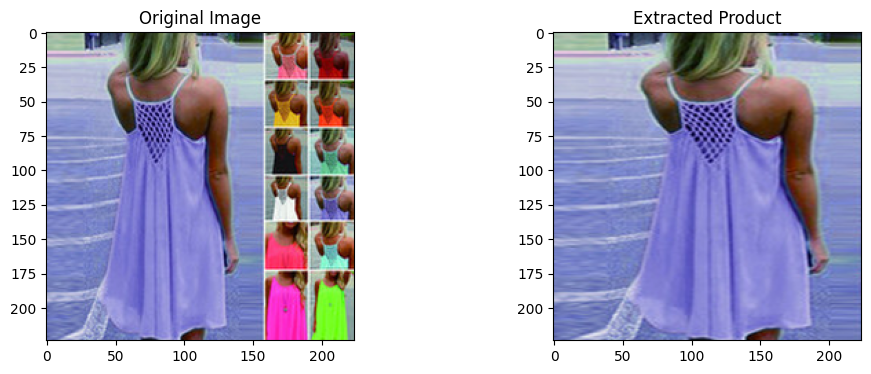

In [ ]:
def extract_main_product(img_array):

    try:
        height = img_array.shape[0]
        main_width = int(height * 0.7)
        main_product = img_array[:, :main_width, :]
        main_product = Image.fromarray(main_product.astype('uint8'))
        main_product = main_product.resize((224, 224), Image.LANCZOS)
        return np.array(main_product)
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

test_extraction = extract_main_product(df['image_pixel'].iloc[0])
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(df['image_pixel'].iloc[0])
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(test_extraction)
plt.title('Extracted Product')
plt.show()

In [ ]:
def process_images(df):
    print("Processing images...")
    processed_images = []
    failed_indices = []

    for idx, img in tqdm(enumerate(df['image_pixel']), total=len(df)):
        processed_img = extract_main_product(img)
        if processed_img is None:
            failed_indices.append(idx)
        processed_images.append(processed_img)

    print(f"\nProcessing complete!")
    print(f"Failed extractions: {len(failed_indices)}")
    return processed_images, failed_indices

processed_images, failed_indices = process_images(df)

Processing images...


100%|██████████| 1338/1338 [00:02<00:00, 633.64it/s]


Processing complete!
Failed extractions: 0


In [ ]:
# Cell 5: Create New DataFrame
def process_df(processed_images, original_df):
    processed_df = pd.DataFrame({
        'image_pixel': processed_images,
        'high_sale': original_df['high_sale']
    })

    # Remove failed processings
    initial_len = len(processed_df)
    processed_df = processed_df.dropna(subset=['image_pixel'])
    final_len = len(processed_df)

    print("\nDataFrame Processed Results:")
    print(f"Initial samples: {initial_len}")
    print(f"Final samples: {final_len}")
    print(f"Removed samples: {initial_len - final_len}")
    print("\nHigh sale distribution in final dataset:")
    print(processed_df['high_sale'].value_counts(normalize=True))

    return processed_df

processed_df = process_df(processed_images, df)


DataFrame Processed Results:
Initial samples: 1338
Final samples: 1338
Removed samples: 0

High sale distribution in final dataset:
high_sale
1    0.591181
0    0.408819
Name: proportion, dtype: float64


Final Dataset Verification:
DataFrame shape: (1338, 2)
Image shape: (224, 224, 3)


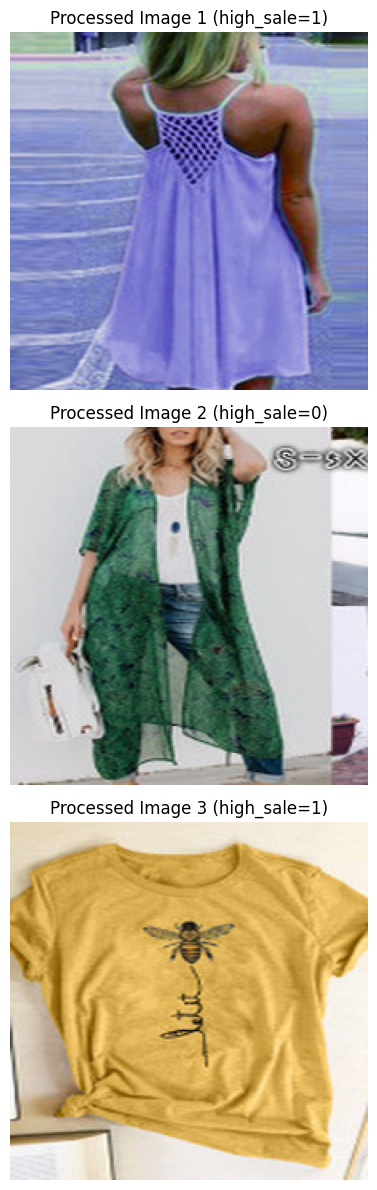

In [ ]:
# Cell 6: Verification
def verify_final_dataset(processed_df, num_samples=3):
    """Verify the final processed dataset"""
    print("Final Dataset Verification:")
    print(f"DataFrame shape: {processed_df.shape}")
    print(f"Image shape: {processed_df['image_pixel'].iloc[0].shape}")

    plt.figure(figsize=(15, 4*num_samples))
    for i in range(min(num_samples, len(processed_df))):
        plt.subplot(num_samples, 1, i+1)
        plt.imshow(processed_df['image_pixel'].iloc[i])
        plt.title(f'Processed Image {i+1} (high_sale={processed_df["high_sale"].iloc[i]})')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

verify_final_dataset(processed_df)

In [ ]:
# Cell 7: Save Processed Data
def save_processed_data(processed_df, output_path):
    """Save the processed DataFrame"""
    processed_df.to_pickle(output_path)
    print(f"Processed data saved to: {output_path}")
    print("Final verification:")
    print(f"- Number of samples: {len(processed_df)}")

save_processed_data(processed_df, 'processed_products.pkl')

Processed data saved to: processed_products.pkl
Final verification:
- Number of samples: 1338


In [ ]:
processed_df.shape

(1338, 2)

In [ ]:
processed_df.head(1)

,image_pixel,high_sale
0,"[[[155, 183, 161], [155, 183, 161], [155, 183,...",1


In [ ]:
df = processed_df

In [ ]:
import cv2
import numpy as np
from PIL import Image, ImageEnhance
from skimage import exposure
from tqdm import tqdm
import pandas as pd

def image_preprocessing_pipeline(df, target_size=(224, 224)):
    """
    Enhanced pipeline for image preprocessing working directly with DataFrame
    """
    def extract_main_product(img_array):
        """Extract main product from grid image."""
        try:
            if img_array is None:
                return None
            if img_array.dtype != np.uint8:
                img_array = (img_array * 255).astype(np.uint8)

            # Extract the main region of interest (ROI)
            height, width, _ = img_array.shape
            main_width = int(height * 0.7)  # Adjust the width dynamically
            main_product = img_array[:, :main_width, :]

            # Resize to target size
            main_product = Image.fromarray(main_product)
            main_product = main_product.resize(target_size, Image.LANCZOS)
            return np.array(main_product)
        except Exception as e:
            print(f"[Error] Extraction failed: {e}")
            return None

    def standardize_lighting(img_array):
        """Standardize lighting conditions using CLAHE."""
        try:
            if img_array is None:
                return None
            lab = cv2.cvtColor(img_array, cv2.COLOR_RGB2LAB)
            l, a, b = cv2.split(lab)

            # Apply CLAHE to L channel
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            cl = clahe.apply(l)

            # Merge channels and convert back to RGB
            limg = cv2.merge((cl, a, b))
            return cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
        except Exception as e:
            print(f"[Error] CLAHE failed: {e}")
            return None

    def remove_noise(img_array):
        """Remove background noise using Non-local Means Denoising."""
        try:
            if img_array is None:
                return None
            if img_array.dtype != np.uint8:
                img_array = (img_array * 255).astype(np.uint8)

            # Non-local Means Denoising
            denoised = cv2.fastNlMeansDenoisingColored(img_array, None, 10, 10, 7, 21)
            return denoised
        except Exception as e:
            print(f"[Error] Denoising failed: {e}")
            return None

    def enhance_image(img_array):
        """Apply image enhancements like contrast and sharpness."""
        try:
            if img_array is None:
                return None

            img = Image.fromarray(img_array)

            # Contrast and sharpness enhancement
            img = ImageEnhance.Contrast(img).enhance(1.2)  # Increased contrast
            img = ImageEnhance.Sharpness(img).enhance(1.2)  # Increased sharpness

            return np.array(img)
        except Exception as e:
            print(f"[Error] Enhancement failed: {e}")
            return None

    def process_single_image(img_array):
        """Process a single image through all steps."""
        try:
            main_product = extract_main_product(img_array)
            if main_product is None:
                return None

            img_balanced = standardize_lighting(main_product)
            if img_balanced is None:
                return None

            img_denoised = remove_noise(img_balanced)
            if img_denoised is None:
                return None

            img_final = enhance_image(img_denoised)
            if img_final is None:
                return None

            # Normalize the image to [0, 1] range
            return img_final.astype(np.float32) / 255.0
        except Exception as e:
            print(f"[Error] Image processing failed: {e}")
            return None

    print("Starting enhanced image preprocessing pipeline...")

    processed_images = []
    failed_indices = []

    for idx, img in tqdm(enumerate(df['image_pixel']), total=len(df)):
        processed_img = process_single_image(img)
        if processed_img is None:
            failed_indices.append(idx)
        processed_images.append(processed_img)

    # Create a new DataFrame with processed images
    df_processed = pd.DataFrame({
        'image_pixel': processed_images,
        'high_sale': df['high_sale']
    })

    # Drop rows with None images
    initial_len = len(df_processed)
    df_processed = df_processed.dropna(subset=['image_pixel'])
    final_len = len(df_processed)

    print("\nProcessing Statistics:")
    print(f"Initial samples: {initial_len}")
    print(f"Successfully processed: {final_len}")
    print(f"Failed processings: {initial_len - final_len}")

    return df_processed

# Example Usage:
# processed_df = image_preprocessing_pipeline(your_df, target_size=(224, 224))


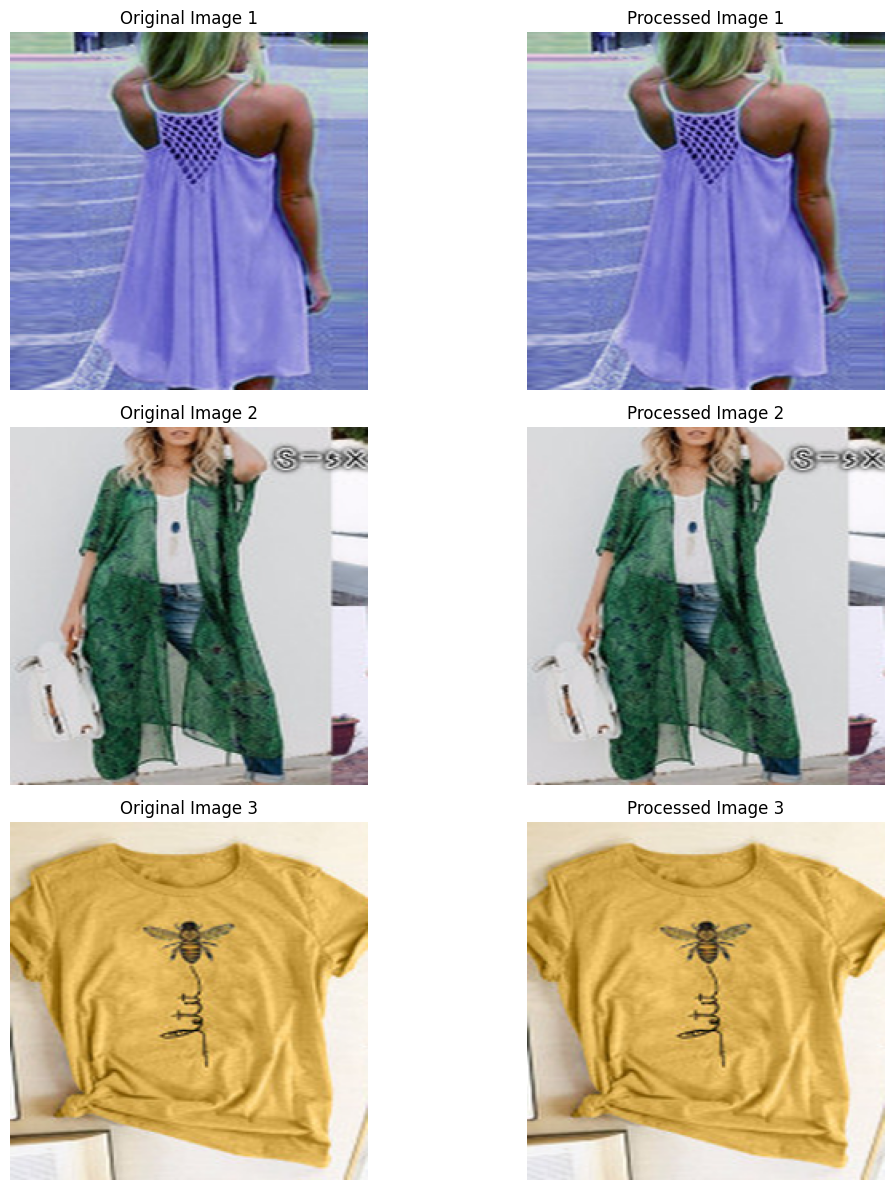

In [ ]:
def visualize_image_comparison(df_original, df_processed, num_samples=5):
    """
    Visualize comparison between original and processed images
    """
    # Ensure we don't try to show more samples than we have
    num_samples = min(num_samples, len(df_processed))

    # Create figure
    fig = plt.figure(figsize=(12, 4*num_samples))

    # Take the first num_samples images
    for idx in range(num_samples):
        # Original image
        plt.subplot(num_samples, 2, 2*idx + 1)
        original_img = df_original['image_pixel'].iloc[idx]
        plt.imshow(original_img)
        plt.title(f'Original Image {idx+1}')
        plt.axis('off')

        # Processed image
        plt.subplot(num_samples, 2, 2*idx + 2)
        processed_img = df_processed['image_pixel'].iloc[idx]
        plt.imshow(processed_img)
        plt.title(f'Processed Image {idx+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# After running your preprocessing pipeline, use it like this:
visualize_image_comparison(df, processed_df, num_samples=3)

In [ ]:
processed_df["image_pixel"][0].shape

(224, 224, 3)

In [ ]:
processed_df.to_pickle('processed.pkl')